In [1]:
import json
from urllib import parse
import pandas as pd
import sqlite3
import numpy as np
from matplotlib import colors, cm, pyplot as plt
import urllib.request
from PIL import Image

In [2]:
PIXELS_X = 910
PIXELS_Y = 910  # equal to the number of scan lines
MZ_MIN = 100.0
MZ_MAX = 1700.0
SCAN_MAX = PIXELS_Y
SCAN_MIN = 1
MZ_PER_TILE = 18.0
TILES_PER_FRAME = int((MZ_MAX - MZ_MIN) / MZ_PER_TILE) + 1
MIN_TILE_IDX = 0
MAX_TILE_IDX = TILES_PER_FRAME-1

In [3]:
MZ_PER_PIXEL_X = MZ_PER_TILE / PIXELS_X
MZ_PER_PIXEL_X

0.01978021978021978

In [4]:
# get the m/z for a x coordinate on a specified tile
def mz_from_tile_pixel_x(tile_id, pixel_x):
    mz_lower = MZ_MIN + (tile_id * MZ_PER_TILE)
    mz = mz_lower + (pixel_x * MZ_PER_PIXEL_X)
    return mz

In [5]:
annotation_file_name = '/Users/darylwilding-mcbride/Downloads/via_export_json (14).json'

In [6]:
# load an annotations file
with open(annotation_file_name) as file:
    annotations = json.load(file)


In [82]:
tile_key = list(annotations.keys())[22]

In [83]:
tile_key

'http://spectra-server-lb-1653892276.ap-southeast-2.elb.amazonaws.com/tile/run/190719_Hela_Ecoli_1to1_02/tile/32/frame/2000-1'

In [84]:
tile_d = annotations[tile_key]
tile_url = tile_d['filename']

splits = parse.urlsplit(tile_url).path.split('/')
run_name = splits[3]
tile_id = int(splits[5])
frame_id = int(splits[7])

tile_regions = tile_d['regions']

In [85]:
run_name, tile_id, frame_id

('190719_Hela_Ecoli_1to1_02', 32, 2000)

In [86]:
len(tile_regions)

8

In [87]:
feature_idx = 0
shape_attributes = tile_regions[feature_idx]['shape_attributes']
region_attributes = tile_regions[feature_idx]['region_attributes']

In [88]:
mz_lower = mz_from_tile_pixel_x(tile_id=tile_id, pixel_x=shape_attributes['x'])
mz_upper = mz_from_tile_pixel_x(tile_id=tile_id, pixel_x=shape_attributes['x'] + shape_attributes['width'])

In [89]:
mz_lower, mz_upper

(685.5736263736263, 688.876923076923)

In [90]:
scan_lower = shape_attributes['y']
scan_upper = shape_attributes['y'] + shape_attributes['height']

In [91]:
scan_lower, scan_upper

(635, 698)

In [92]:
db_file_name = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/converted-databases/exp-dwm-test-run-{}-converted.sqlite'.format(run_name)

In [93]:
db_conn = sqlite3.connect(db_file_name)
raw_df = pd.read_sql_query('select mz,scan,intensity from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and frame_id == {}'.format(mz_lower, mz_upper, scan_lower, scan_upper, frame_id), db_conn)
db_conn.close()

#### segment the raw data to reveal the isotopes in the feature

In [94]:
X = raw_df[['mz','scan']].values

In [95]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
raw_df['scan_scaled'] = raw_df.scan / 50.0
X_scaled = raw_df[['mz','scan_scaled']].values

# cluster the data into five clusters
dbscan = DBSCAN(eps=0.2, min_samples = 3)
clusters = dbscan.fit_predict(X_scaled)

In [96]:
raw_df['cluster'] = clusters

In [97]:
raw_df.sample(n=5)

,mz,scan,intensity,scan_scaled,cluster
60,686.833676,662,23,13.24,2
132,688.305751,665,29,13.30,5
106,687.816255,652,68,13.04,4
100,687.351601,646,24,12.92,3
58,686.361137,660,122,13.20,1


In [98]:
import peakutils

In [99]:
colour_map = plt.get_cmap('Dark2')
norm = colors.Normalize(vmin=raw_df.cluster.min(), vmax=raw_df.cluster.max(), clip=False)

In [100]:
centroids_l = []
for group_name,group_df in raw_df.groupby(['cluster'], as_index=False):
    if group_name >= 0:
        mz_centroid = peakutils.centroid(group_df.mz, group_df.intensity)
        scan_centroid = peakutils.centroid(group_df.scan, group_df.intensity)
        c = colour_map(norm(group_name), bytes=False)[:3]
        centroids_l.append((group_name, mz_centroid, scan_centroid, c))
centroids_df = pd.DataFrame(centroids_l, columns=['cluster','mz_centroid','scan_centroid','colour'])

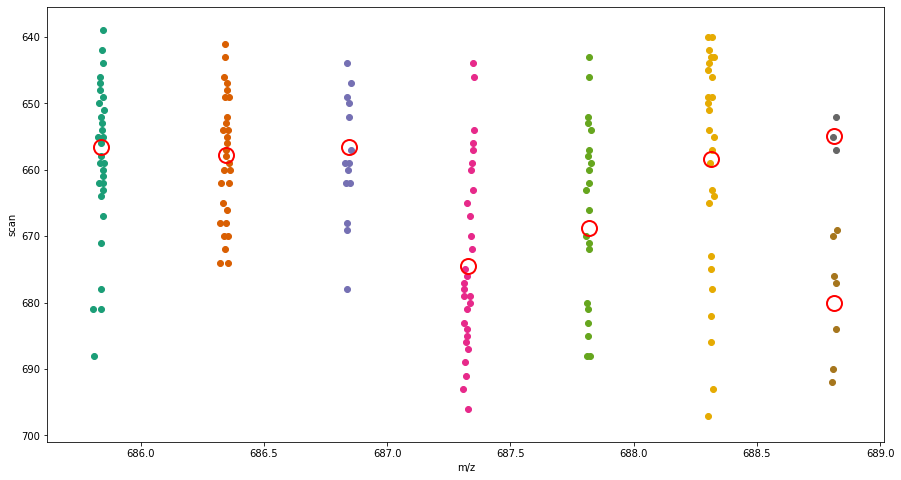

In [101]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

for idx,row in centroids_df.iterrows():
    cluster_df = raw_df[raw_df.cluster == row.cluster]
    plt.scatter(cluster_df.mz, cluster_df.scan, c=np.array([row.colour]))
    plt.plot(row.mz_centroid, row.scan_centroid, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='cluster centroid')

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

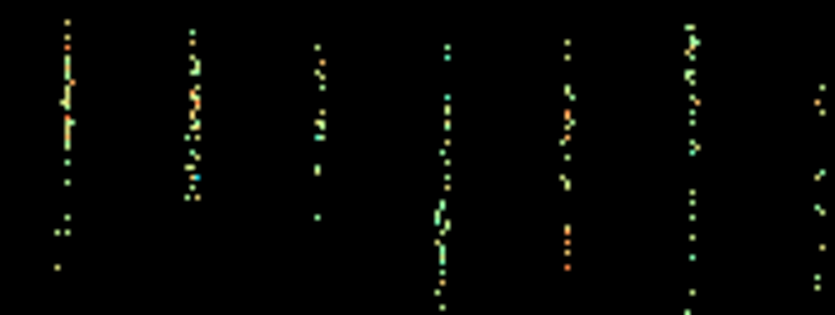

In [102]:
feature_x = shape_attributes['x']
feature_y = shape_attributes['y']
feature_width = shape_attributes['width']
feature_height = shape_attributes['height']

image = Image.open(urllib.request.urlopen(tile_url))
image = image.crop((feature_x, feature_y, feature_x+feature_width, feature_y+feature_height))
image.resize((image.width*5,image.height*5))